In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data loading

In [3]:
data = pd.read_csv('subreddit_body.csv')

In [4]:
df = data[['body', 'subreddit']]

In [5]:
df.head()

,body,subreddit
0,oh morality law work u think exists fed basica...,technology
1,sign contract agree really good deal compare o...,technology
2,logic equivalent people sell gun ammo responsi...,technology
3,sure could go four core like competition seem ...,technology
4,near term hydrogen simply n t compete alternat...,technology


In [6]:
df.subreddit.value_counts()

subreddit
politics       9993
science        9985
programming    9981
technology     9974
gaming         9885
Name: count, dtype: int64

In [7]:
df = pd.concat([df[df['subreddit'] == subreddit].sample(4000, random_state=42)
               for subreddit in df['subreddit'].unique()]).reset_index(drop=True)
df['subreddit'].value_counts()

subreddit
technology     4000
politics       4000
science        4000
gaming         4000
programming    4000
Name: count, dtype: int64

# Bow and TF-IDF transformation

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

repr = 'bow' # 'bow' or 'tfidf'

if repr == 'bow':
	vectorizer = CountVectorizer()
	bow_matrix = vectorizer.fit_transform(df['body'])	
	X = bow_matrix.toarray()
else:
	vectorizer = TfidfVectorizer(max_features=1000)
	X = vectorizer.fit_transform(df['clean_text']).toarray()

print(f'Data after {repr} representation: {X.shape}')

Data after bow representation: (20000, 22388)


# Hidden Markov Models classification

In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['subreddit'])

steps = ['SelectPercentil', 'LDA']  # 'SVD', 'PCA', 'SelectPercentile', 'LDA'

X_new, X_transformed = None, None

if 'SelectPercentile' in steps:
	selector = SelectPercentile(percentile=10)
	X_new = selector.fit_transform(X, y)
	print(f'Data after SelectPercentile: {X_new.shape}')
else:
	X_new = X

if 'SVD' in steps:
	svd = TruncatedSVD(n_components=50)  # Choose number of components
	X_transformed = svd.fit_transform(X_new)
	print(f'Data after SVD: {X_transformed.shape}')
elif 'PCA' in steps:
	pca = PCA(n_components=10)
	X_transformed = pca.fit_transform(X_new)
	print(f'Data after PCA: {X_transformed.shape}')
elif 'LDA' in steps:
	lda = LatentDirichletAllocation(n_components=20)
	X_transformed = lda.fit_transform(X_new)
	print(f'Data after LDA: {X_transformed.shape}')
else:
	X_transformed = X_new
	print(f'Data : {X_transformed.shape}')

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

Data after LDA: (20000, 20)


In [52]:
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd
from hmmlearn import hmm

def compute_transition_array(sequence):
    states = np.unique(sequence)
    n_states = len(states)
    M = np.zeros((n_states, n_states))
    for (i,j) in zip(sequence, sequence[1:]):
        M[i][j] += 1
    return M/M.sum(1).reshape(-1, 1)

def return_init_params(train_data, n_states, model = None):
    if model is None:
        gm = GaussianMixture(n_components=n_states)
    else:
        gm = GaussianMixture(
            n_components = n_states,
            means_init = model.means_,
            weights_init = model.startprob_,
            precisions_init = np.linalg.inv(model.covars_)
        )
        transmat = model.transmat_

    gm.fit(train_data)
    states = gm.predict(train_data)
    transmat = compute_transition_array(states)
    edge = gm.means_
    covs = gm.covariances_.diagonal(0, 1, 2)
    pda = gm.weights_/gm.weights_.sum()
    
    return transmat, covs, pda, edge, gm

In [53]:
model = None
not_converged = True

n_states = 10

while not_converged:
		model = None
		transmat_init, covars_init, startprob_init, means_init, gm = return_init_params(X_train, n_states, model)
		
		model = hmm.GaussianHMM(
		n_components=n_states, 
		algorithm='viterbi', 
		covariance_type='diag',
		)
		model.init_params = ''
		model.transmat_ = transmat_init
		model.covars_ = covars_init
		model.startprob_ = startprob_init
		model.means_ = means_init

		sequences = [sample.reshape(-1, 1) for sample in X_train]	

		all_sequences = np.vstack(sequences)  # Combine all samples into a single array
		lengths = [len(seq) for seq in sequences]

		model.fit(all_sequences, lengths)

		try:
				states = [model.decode(seq.reshape(-1, 1), algorithm='viterbi')[1] for seq in X_train]
				not_converged = False
		except:
				print('Model did not converge. Trying again...')

In [54]:
states = [model.decode(seq.reshape(-1, 1), algorithm='viterbi')[1] for seq in X_train]
states = np.vstack(states)
assert states.shape[0] == y_train.shape[0]

In [55]:
import xgboost as xgb

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=5,  # Number of classes in the dataset
    max_depth=5,  # Depth of the decision trees
    learning_rate=0.25,  # Learning rate for boosting steps
    n_estimators=100,  # Number of boosting rounds (trees)
)

In [56]:
states.shape

(14000, 20)

In [57]:
xgb_model = xgb_model.fit(states, y_train)

In [58]:
test_states = [model.decode(seq.reshape(-1, 1), algorithm='viterbi')[1] for seq in X_test]
test_states = np.vstack(test_states)

In [59]:
y_pred = xgb_model.predict(test_states)

In [60]:
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7067
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1236
           1       0.68      0.77      0.72      1200
           2       0.78      0.71      0.74      1163
           3       0.71      0.74      0.72      1212
           4       0.56      0.54      0.55      1189

    accuracy                           0.71      6000
   macro avg       0.71      0.71      0.71      6000
weighted avg       0.71      0.71      0.71      6000



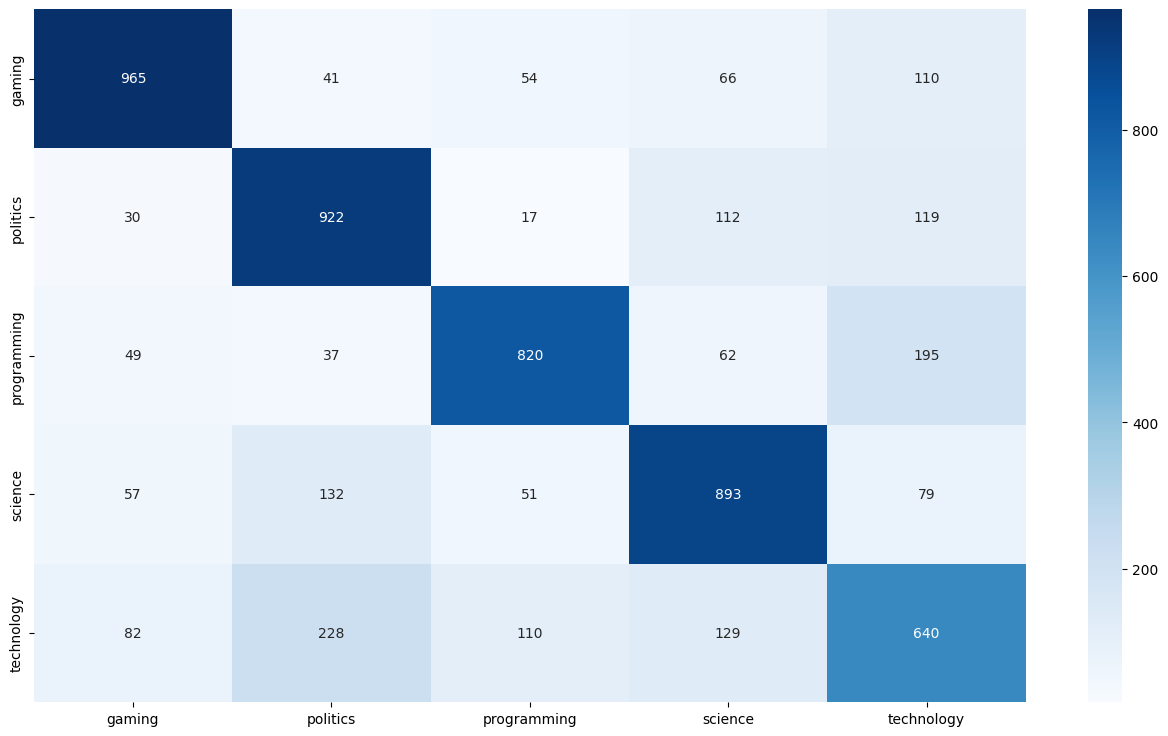

In [61]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.savefig('report/src/images/hmm_xgb_confusion_matrix.png')
plt.show()

In [62]:
label_encoder.classes_

array(['gaming', 'politics', 'programming', 'science', 'technology'],
      dtype=object)

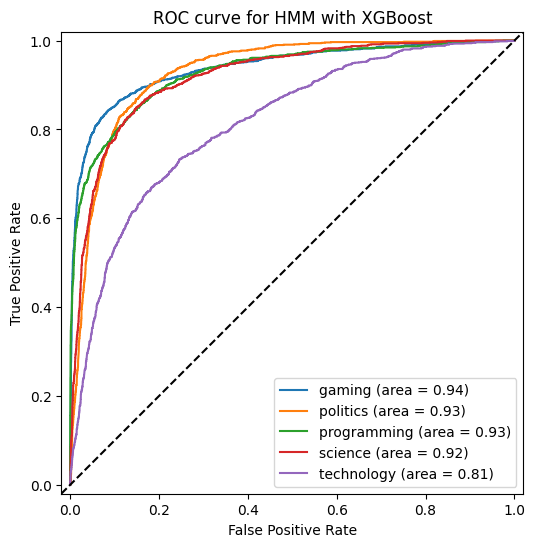

In [63]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

labels = label_encoder.classes_


y_score = xgb_model.predict_proba(test_states)

# Plot ROC curve
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
limits = [-0.02, 1.02]
plt.figure(figsize=(6, 6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (area = {roc_auc:.2f})')
plt.plot(limits, limits,'k--')
plt.xlim(limits)
plt.ylim(limits)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title(f'ROC curve for HMM with XGBoost')
plt.gca().set_aspect('equal')
plt.savefig(f'report/src/images/roc_hmm_xgboost.png', bbox_inches='tight')
plt.show()